In [1]:
# import modules
%matplotlib inline

import os
import pylab
import random
import pandas as pd
import numpy as np
import cPickle as pkl
from skimage.util import crop
from skimage import transform
from lasagne import layers, updates
from scipy.misc import imread, imresize
from theano.tensor.nnet import softmax
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from nolearn.lasagne import NeuralNet, BatchIterator

project_root = 'workspace/.project/project'
script_root = os.path.join(os.path.expanduser('~'), project_root, 'scripts')
model_root = os.path.join(os.path.expanduser('~'), project_root, 'models')
data_root = os.path.join(os.path.expanduser('~'), project_root, 'datasets')
chars74k_root = os.path.join(data_root, 'English')

Using gpu device 0: GeForce GT 740M (CNMeM is disabled)


In [29]:
# load train_test set
# chars74k
data = pd.read_csv(os.path.join(script_root, 'LISTFILE.txt'), sep = ' ', header = None)
data_x = np.zeros((data.shape[0], 1, 32, 32))
data_y = np.ones((data.shape[0], ), dtype = int)

mms = MinMaxScaler()

for idx, path in enumerate(data[0]):
    img = imread(os.path.join(chars74k_root, path))
    img = imresize(img, (32, 32))
    if len(img.shape) == 3:
        data_x[idx, ...] = mms.fit_transform(img.dot([0.299, 0.587, 0.144]))
    else:
        data_x[idx, ...] = mms.fit_transform(img.astype(float))

In [7]:
# preprocess
# chars74k
data_x /= data_x.std(axis = None)
data_x -= data_x.mean()

In [44]:
# double data and concat
data1_x = data_x
data2_x = data_x

data1_y = data_y
data2_y = np.zeros((data_y.shape[0], ), dtype = 'int32')

final_data_x = np.concatenate([data1_x, data2_x], axis = 0)
final_data_y = np.concatenate([data1_y, data2_y], axis = 0)

In [45]:
# check again
final_data_x = final_data_x.astype('float32')
final_data_y = final_data_y.astype('int32')

print final_data_x.shape, final_data_y.shape

(15410, 1, 32, 32) (15410,)


In [131]:
class TransIterator(BatchIterator):
    def fast_warp(self, img, tf, output_shape, mode = 'nearest'):
        return transform._warps_cy._warp_fast(img, tf.params, output_shape = output_shape, mode = mode)
    
    def transform(self, Xb, yb):
        Xb, yb = super(TransIterator, self).transform(Xb, yb)
        
        if yb is None:
            return Xb, yb
        else:
            Xb_pos = Xb[yb > 0]
            yb_pos = yb[yb > 0]

            Xb_neg = Xb[yb == 0]
            yb_neg = yb[yb == 0]

            Xb_aug_pos = np.empty(shape = (Xb_pos.shape[0], 1, 32, 32), dtype = 'float32')
            Xb_aug_neg = np.empty(shape = (Xb_neg.shape[0], 1, 32, 32), dtype = 'float32')

            dorotate = random.randint(-5,5)

            trans_1_pos = random.randint(-4,4)
            trans_2_pos = random.randint(-4,4)

            trans_1_neg = random.choice([random.randint(-31,-10), random.randint(10, 31)])
            trans_2_neg = random.choice([random.randint(-31,-10), random.randint(10, 31)])

            center_shift   = np.array((32, 32)) / 2. - 0.5
            tform_center   = transform.SimilarityTransform(translation=-center_shift)
            tform_uncenter = transform.SimilarityTransform(translation=center_shift)

            tform_aug_pos = transform.AffineTransform(
                                            rotation = np.deg2rad(dorotate),
                                            translation = (trans_1_pos, trans_2_pos))

            tform_aug_neg = transform.AffineTransform(
                                            rotation = np.deg2rad(dorotate),
                                            translation = (trans_1_neg, trans_2_neg))

            tform_pos = tform_center + tform_aug_pos + tform_uncenter
            tform_neg = tform_center + tform_aug_neg + tform_uncenter

            for j in range(Xb_pos.shape[0]):
                Xb_aug_pos[j][0] = self.fast_warp(Xb_pos[j][0], tform_pos,
                                              output_shape = (32, 32))

            for j in range(Xb_neg.shape[0]):
                Xb_aug_neg[j][0] = self.fast_warp(Xb_neg[j][0], tform_neg,
                                              output_shape = (32, 32))

            Xb_aug = np.concatenate([Xb_aug_pos, Xb_aug_neg], axis = 0)
            yb_aug = np.concatenate([yb_pos, yb_neg], axis = 0)

            return Xb_aug, yb_aug

In [132]:
# setting nn 
net = NeuralNet(
    layers = [
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('conv3', layers.Conv2DLayer),
        ('dropout3', layers.DropoutLayer),
        ('hidden4', layers.DenseLayer),
        ('output', layers.DenseLayer),
    ],

    input_shape = (None, 1, 32, 32),
    conv1_num_filters = 32, conv1_filter_size = (5, 5),
    pool1_pool_size = (2, 2),
    dropout1_p = 0.2,
    conv2_num_filters = 64, conv2_filter_size = (5, 5),
    pool2_pool_size = (2, 2),
    dropout2_p = 0.3,
    conv3_num_filters = 128, conv3_filter_size = (5, 5),
    dropout3_p = 0.5,
    hidden4_num_units = 128,
    output_num_units = 2, output_nonlinearity = softmax,

    batch_iterator_train = TransIterator(batch_size = 256),
    batch_iterator_test = TransIterator(batch_size = 256),

    update=updates.adam,

    regression = False,
    max_epochs = 200,
    verbose = 1,
)

In [201]:
# train and test nn
net.fit(final_data_x, final_data_y);

     20       0.36742       0.92503      0.39720      0.66376  13.19s
     21       0.64655       0.40303      1.60425      0.88431  12.85s
     22       0.37878       0.47318      0.80050      0.85757  12.85s
     23       0.36143       0.51342      0.70396      0.83624  12.84s
     24       0.42710       0.41248      1.03544      0.86809  12.84s
     25       0.38977       0.49440      0.78838      0.81280  12.91s
     26       0.99950       3.78441      0.26411      0.53696  12.85s
     27       0.88138       0.51375      1.71557      0.80288  12.84s
     28       0.47281       0.39685      1.19142      0.87428  12.85s
     29       0.33457       0.40743      0.82118      0.87061  12.85s
     30       0.36014       0.46808      0.76939      0.85457  12.86s
     31       0.36482       0.34075      1.07064      0.88221  12.85s
     32       0.27936       0.35392      0.78935      0.87590  12.84s
     33       0.25393       0.27427      0.92582      0.90325  12.86s
     34       0.2465

In [243]:
net.save_params_to(model_root + '/detector_4.pkl')

(768, 1024, 3)


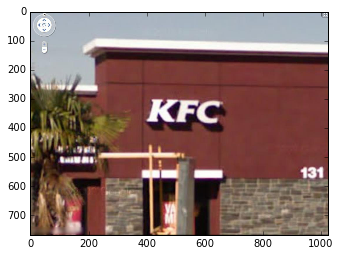

In [244]:
# test image
from scipy.misc import imread as ims
img = ims(data_root + '/svt/svt1/img/00_13.jpg')#[292:450, 176:850, :]#img -> 00_12
print img.shape
# image[y:y + image_height, x:x + image_width, :]
pylab.imshow(img)
pylab.show()

In [253]:
from sklearn.feature_extraction import image
patches = image.extract_patches(img, (80, 80, 3), extraction_step = 5)
print patches.shape

(138, 189, 1, 80, 80, 3)


In [254]:
from scipy.misc import imresize
new_lst = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        new_lst.append(imresize(patches[i, j, 0, :, :, :], (32, 32)))
        
print len(new_lst)

26082


In [255]:
new_list = np.stack(new_lst)
new_list = new_list.dot([0.299, 0.587, 0.144])
tester = new_list.reshape(patches.shape[0]*patches.shape[1], 1, 32, 32)

In [256]:
tester /= tester.std(axis = None)
tester -= tester.mean()
tester = tester.astype('float32')

In [257]:
print tester.shape

(26082, 1, 32, 32)


In [258]:
preder = net.predict_proba(tester)

In [259]:
heatmap = preder[:, 1].reshape((patches.shape[0], patches.shape[1]))
print heatmap.shape

(138, 189)


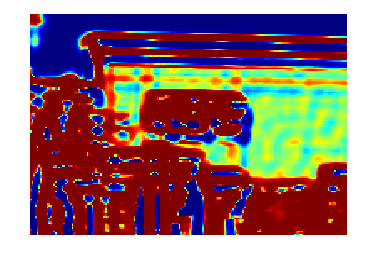

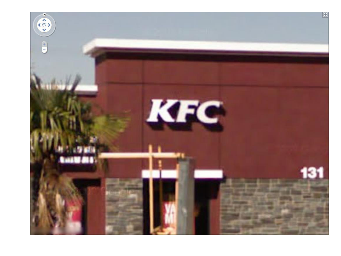

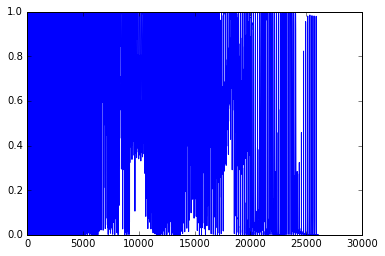

In [260]:
pylab.pcolor(heatmap[::-1])
pylab.axis('off')
pylab.show()
pylab.imshow(img)
pylab.axis('off')
pylab.show()
pylab.plot(heatmap[::-1].ravel())
pylab.show()

In [261]:
preder.shape

(26082, 2)